## Task 2

### Import modules and path

In [77]:
import matplotlib.pyplot as plt
import os
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn.functional as F

base_path = "./../Dataset/cifake"
train_path = os.path.join(base_path, "train")

### Loading datasets using ImageFolder and DataLoaders

transform: convert pixel values to tensors and normalising it to range [0, 1].
There are 100,000 images for training (50k per class), we extract 20% of these as validation class.

In [93]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu") #if you're using mac
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #if not mac

In [94]:
# convert to tensors and normalise pixel values to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

Splitting validation set

In [95]:
val_ratio = 0.2
val_size = int(val_ratio * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(f"Validation Dataset Shape: {val_dataset.__len__()}")
print(f"Training Dataset Shape: {train_dataset.__len__()}")

Validation Dataset Shape: 20000
Training Dataset Shape: 80000


In [96]:
batch_size = 10000

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")  # (batch, channel, height, width)
print(f"Batch label shape: {labels.shape}")  # (batch,)
print(f"Labels: {labels}")

Batch image shape: torch.Size([10000, 3, 32, 32])
Batch label shape: torch.Size([10000])
Labels: tensor([1, 0, 1,  ..., 1, 1, 0])


### Real CIFAR-10 vs. Computer Generated CIFAR-10
Top row shows the real images whilst bottom row shows the fake images

In [97]:
def show_real_vs_fake_images(data_loader, class_names):
    real_images = []
    fake_images = []

    for features, labels in data_loader:
        features, labels = features.to(device), labels.to(device)
        for i in range(len(labels)):
            if len(real_images) < 2 and labels[i].item() == 1:  # real images
                real_images.append(features[i])
            elif len(fake_images) < 2 and labels[i].item() == 0:  # fake images
                fake_images.append(features[i])
            if len(real_images) == 2 and len(fake_images) == 2:
                break
        if len(real_images) == 2 and len(fake_images) == 2:
            break

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle("Top Row: Real CIFAR-10 | Bottom Row: AI-Generated", fontsize=14)

    for i, img in enumerate(real_images):
        img = img.permute(1, 2, 0)  # convert (C, H, W) to (H, W, C)
        # img = img / 2 + 0.5  # pixel values from [-1, 1] to [0, 1]
        img = img.cpu().numpy()
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Label: {class_names[1]}")
        axes[0, i].axis("off")

    for i, img in enumerate(fake_images):
        img = img.permute(1, 2, 0)
        # img = img / 2 + 0.5  
        img = img.cpu().numpy()
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Label: {class_names[0]}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

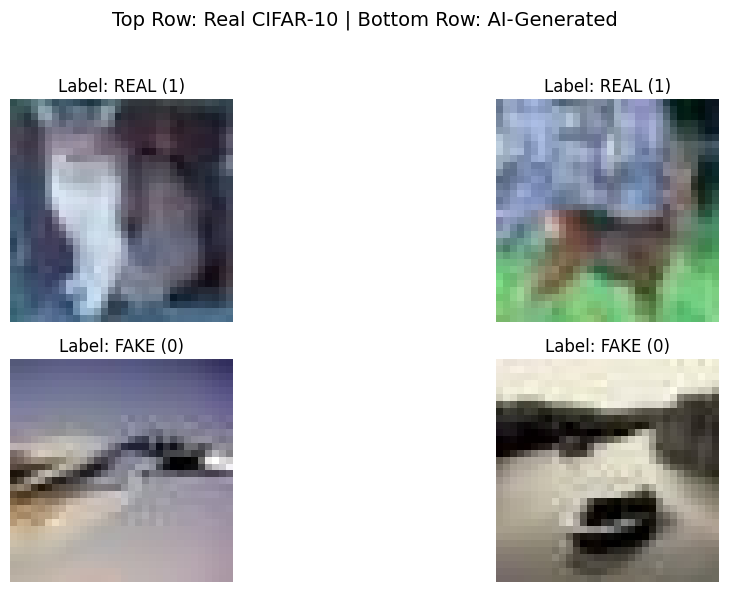

In [98]:
class_names = ["FAKE (0)", "REAL (1)"]
show_real_vs_fake_images(train_loader, class_names)

### Creating our CNN model

We're creating a model... 

For the last layer, we don't have to pass the output of fc2 into Sigmoid because the BCEWithLogitsLoss automatically passes incoming values through Sigmoid before calculating loss.

In [99]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=15, kernel_size=3, stride=1,
                               padding=1)  # Input: (3, 32, 32) Output: (15, 32, 32)
        self.conv2 = nn.Conv2d(in_channels=15, out_channels=8, kernel_size=3, stride=1,
                               padding=1)  # Input: (32, 32, 32) Output: (8, 32, 32)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # dimension / 2

        self.fc1 = nn.Linear(in_features=8 * 8 * 8, out_features=128)  # flatten output from pool
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: (15, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # Output: (8, 8, 8)

        x = x.view(-1, 8 * 8 * 8)  # flatten to (batch_size, 8 * 8 * 8)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x) # no need for activation, BCELossWithLogits combines sigmoid

        return x

In [100]:
from torchsummary import summary

model = CNNModel()
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 15, 32, 32]             420
         MaxPool2d-2           [-1, 15, 16, 16]               0
            Conv2d-3            [-1, 8, 16, 16]           1,088
         MaxPool2d-4              [-1, 8, 8, 8]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 67,301
Trainable params: 67,301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.17
Params size (MB): 0.26
Estimated Total Size (MB): 0.44
----------------------------------------------------------------


### Hyperparameters

Set epochs, learning rate scheduler, L1 & L2 regulariser and optimiser.

In [101]:
model.to(device)
epochs = 20
lambda_L1 = 0
lambda_L2 = 1e-3
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) #learning rate

### A full process of training one single batch.
First we set model to train mode, this will enable dropout. Move data to device to speed up training. After getting the output from forwarding through model, calculate L1 or L2 regularization before calculating loss for single batch.

Compute gradients and update the weights for each parameters. Clear gradients, then return the scalar value of loss.  

In [102]:
def batch_train(inputs, labels):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)

    # Forward pass, receive raw outputs
    outputs = model(inputs)

    # Required by the loss function, turn shape from [batch_size] to [batch_size, 1]
    labels = labels.unsqueeze(1).float()

    # L1 penalty
    l1_regularization = 0
    if lambda_L1 > 0.0:
        for param in model.parameters():
            l1_regularization += torch.norm(param,1)
        
    # L2 euclidean penalty
    l2_regularization = 0
    if lambda_L2 > 0.0:
        for param in model.parameters():
            l2_regularization += torch.norm(param,2)
    
    batch_loss = loss_fn(outputs, labels) + lambda_L1 * l1_regularization + lambda_L2 * l2_regularization

    # computes the gradients of the loss using backpropagation
    batch_loss.backward()
    # updates the model parameters
    optimizer.step()
    # avoid gradient accumulation across batches
    optimizer.zero_grad()
    
    return batch_loss.item()

### Implements Early Stopping
Stops training if val_loss is not improving or val_loss is no longer smaller than training_loss

In [103]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.02):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.early_stop = False
        self.best_loss = None

    def __call__(self, val_loss, training_loss):
        if val_loss > training_loss:
            self.early_stop = True
            print(f"Val_loss no longer higher than training loss")
        elif self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Val_loss no longer improving")
        else:
            self.best_loss = val_loss
            self.counter = 0

calculates validation loss for a batch

In [104]:
@torch.no_grad()
def batch_val(inputs, labels):
    model.eval()
    inputs, labels = inputs.to(device), labels.to(device)
    
    outputs = model(inputs)
    labels = labels.unsqueeze(1).float()
    val_loss = loss_fn(outputs, labels)
    return val_loss.item()

### Train model
Looping through train_loader and val_loader and calculate loss

In [105]:
def train_model():
    early_stopping = EarlyStopping(patience=5, delta=0.02)
    final_epoch = 0
    
    loss_hist = []
    val_loss_hist = []

    for epoch in range(epochs):
        batch_losses = []
        batch_val_losses = []
        
        for i, data in enumerate(iter(train_loader)):
            inputs, labels = data
            batch_loss = batch_train(inputs, labels)
            batch_losses.append(batch_loss) # track loss for every batch
            
        for i, data in enumerate(iter(val_loader)):
            inputs, labels = data
            val_loss = batch_val(inputs, labels)
            batch_val_losses.append(val_loss)

        one_epoch_loss = np.array(batch_losses).mean() # calculate loss for one epoch
        one_epoch_val_loss = np.array(batch_val_losses).mean()
        early_stopping(one_epoch_val_loss, one_epoch_loss)
        
        loss_hist.append(one_epoch_loss) # track loss for every epoch
        val_loss_hist.append(one_epoch_val_loss)
        final_epoch = epoch
        
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch}, training loss: {one_epoch_loss:.4f}, validation loss: {one_epoch_val_loss:.4f}")
            break

        scheduler.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, training loss: {one_epoch_loss:.4f}, validation loss: {one_epoch_val_loss:.4f}")

    return loss_hist, val_loss_hist, final_epoch

In [106]:
loss_history, val_loss_history, final_epoch = train_model()

Epoch 5/20, training loss: 0.5320, validation loss: 0.5032
Epoch 10/20, training loss: 0.4825, validation loss: 0.4628
Epoch 15/20, training loss: 0.4644, validation loss: 0.4485
Val_loss no longer improving
Early stopping at epoch 17, training loss: 0.4593, validation loss: 0.4441


### Saving model

In [107]:
torch.save(model.to('cpu').state_dict(), '10000batch.pth')

### Plotting training loss and validation loss

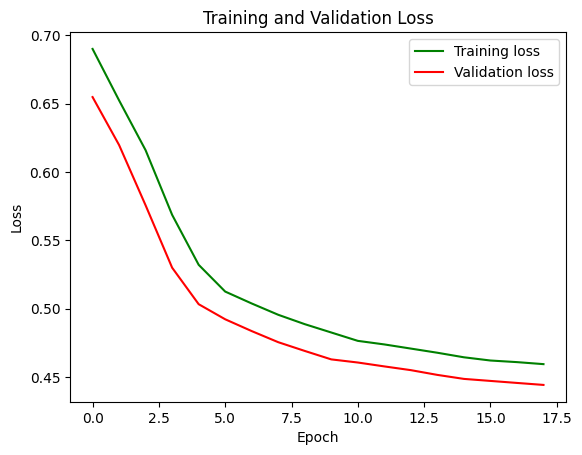

In [108]:
y_arr = np.arange(final_epoch + 1)
plt.plot(y_arr, loss_history, 'g', label='Training loss')
plt.plot(y_arr, val_loss_history, 'r', label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()